# Analysis Techniques - Statistical Methods 


## Universidade de Santiago 

---

## Lecture IV b -  Hypothesis test and regression - practical example

*Author: Jose A. Hernando*, February 2020

*Instituto Galego de Altas Enerxías. Universidade de Santiago de Compostela, Spain.*

In [12]:
import time

print(' Last Execution ', time.asctime())

 Last Execution  Wed Feb 12 15:33:15 2020


In [13]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize

# possible styles: ggplot (simplicity), bmh (scientify data), 
plt.style.context('seaborn-colorblind')

import htcore    as htcore
import htcatalog as htcata
import httoys    as httoys
import htplot    as htplot

# ploting images
from IPython.display import display, Image

----

## Practical example - hypothesis testing - CI a la Feldman-Cousins

**Example** Consider an experiment that measures an exponential spectrum and an a gaussian peak. The gaussian peak is our alternative hypothesis. Given an observation data compute the CI a la FC a 90% CL.


First we generate an observation, $x_0$, an exponential spectrum with a gaussian peak.

The number of events in the gaussian peak is our paremter of interest $\mu$

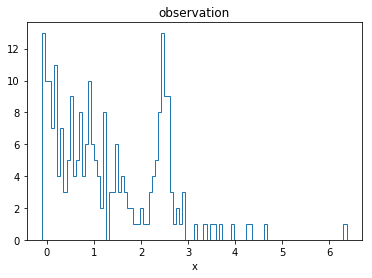

In [38]:
import blind 
# list of parameters, the nu_peak is the parameter of interest *mu*
nu_peak, nub, tau, peak_mu, peak_sigma = blind.nupeak_1, 200., -0.1, 2.5, 0.1
par = [nu_peak, nub, tau, peak_mu, peak_sigma]
rv  = htcata.extended_norm_expon
x0 = rv.rvs(*par, size = 1)[0]
plt.hist(x0, 100, histtype = 'step'); plt.xlabel('x'); plt.title('observation');

Next, we compute the best estimate of the number of events in the gaussian peak, $\hat{\mu}(x_0)$ using MLE. 

We assume that we know all the other parameters but the number of events in the peak. We will see later how proceed if we do not know the other parameters.

In [39]:
mask = (True, False, False, False, False) # Fit only the nu-peak
ht = htcore.htcomposite(rv, par, mask = mask)
parbest0 = ht.parbest(x0)
muhat0   = parbest0[0]
print('mu-hat(x0) :', muhat0)

mu-hat(x0) : 44.42510986328125


We scan along $\mu$ and compute $t_\mu(x_0)$.

$$
t_\mu(x_0) = - 2 \ln \frac{\mathcal{L}(x_0 | \mu)}{\mathcal{L}(x_0 | \hat{\mu}(x_0))}
$$

In in order words:

$$
t_\mu(x_0) = - 2 \ln \mathcal{L}(x_0| \mu) + 2 \ln \mathcal{L}(x_0 |\hat{\mu}(x_0))  = - 2 \Delta \ln \mathcal{L}
$$

In [40]:
def plt_llscan(ht, x0, mu0, beta, mul, mup, nbins):
    mus   = np.linspace(mul, mup, nbins)
    tmu0s = [ht.tmu(x0, mui, mu0 = mu0) for mui in mus]
    plt.plot(mus, tmu0s, label = r'$t_\mu(x_0)$'); 
    plt.plot(mus, 1.*np.ones(nbins));
    plt.xlabel(r'$\mu$'); plt.ylabel(r'$-2 \Delta \ln \mathcal{L} = t_\mu(x_0)$');
    plt.grid(); plt.legend();
    ci = ht.tmu_cint(x0, parbest = parbest0, beta = beta)
    htplot.prt_wilks_pvalues(beta, ci_central = ci)
    return ci

Now, we are going to scan $t_\mu(x_o) = -2 \Delta \ln \mathcal{L}(x | \mu)$ along the $\mu$ parameter to set the CI.

central CI  : [37.54744733 51.98032288] at  68 % CL


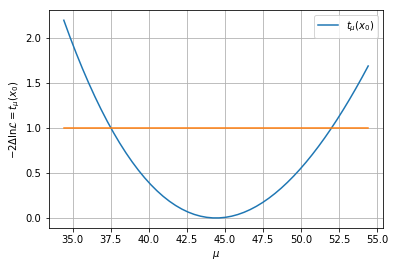

In [41]:
mu0, mul, mup, nbins, beta  = 0., muhat0 - 10, muhat0 + 10, 50, 0.68
ci = plt_llscan(ht, x0, mu0, beta, mul, mup, nbins)
mu_lower, mu_upper = ci

In [42]:
def tmus_rvs(ht, par, mu, mu0 = None, size = 100):
    print(' generating', size, ' events with mu ', mu, 'and mu0 ', mu0)
    parmu    = np.array(par);
    par[0]   = mu
    xs       = ht.rvs(*par, size = size)
    mubests  = np.array([ht.mubest(xi, mu0 = mu0)[0] for xi in xs]) 
    tmus     = np.array([ht.tmu(xi, mu, mu0 = mu0) for xi in xs])
    sel      = tmus >= 0.
    return tmus[sel], mubests[sel]

def plt_tmus(tmus, tmu0 = None, mu = None):
    if (tmu0 is not None) and (mu is not None):
        print(' tmu ', tmu0, ' of x0 at mu ', mu)
    ys, xs, _ = plt.hist(tmus, 100, histtype = 'step', density = True);
    if (tmu0 is None): return
    xs = 0.5*(xs[1:] + xs[:-1]) 
    plt.yscale('log'); plt.xlabel(r'$t_\mu$');
    sel = (xs >= tmu0)
    print(' p-value :', 1.*np.sum([tmus >= tmu0])/(1.*size))
    plt.fill_between(xs[sel], ys[sel], color = 'red', alpha = 0.5);
    return

def plt_muhats(muhats):
    plt.hist(muhats, 100, histtype = 'step'); #plt.yscale('log');
    plt.xlabel(r'$\hat{\mu}$')
    return

In [43]:
def plt_mu_segment(ht, par, x0, mu, mu0, size):
    tmus, muhats = tmus_rvs(ht, par, mu, mu0 = mu0, size = 500)
    tmu0 = ht.tmu(x0, mu = mu, mu0 = mu0)
    plt.subplot(2, 1, 1)
    plt_tmus(tmus, tmu0, mu)
    plt.subplot(2, 1, 2)
    plt_muhats(muhats);
    plt.tight_layout()

We are going to obtain the pdf, $g(t_\mu)$, of the FC variable, $t_\mu$. 
For that we are going to simulate a large number of experiments with $\mu$, for each one we compute $t_\mu(x)$.

Remember that:

$$
t_\mu(x) = -2 \ln \frac{\mathcal{L}(x | \mu)}{\mathcal{L}(x | \hat{\mu}(x))}
$$

Now we compute $t_\mu(x_0)$ for the observed data and where in the $g(t_\mu | \mu)$ pdf is located our observation. We generate $m$ (*size*) experiments to obtain $g(t_\mu | \mu). $For the case $\mu = \hat{\mu}(x_0)$, $x_0$ has to be a very good measurement with a p-value one. The color area corresponds to the p-value.

 generating 500  events with mu  44.42510986328125 and mu0  0.0
 tmu  0.0  of x0 at mu  44.42510986328125
 p-value : 1.0


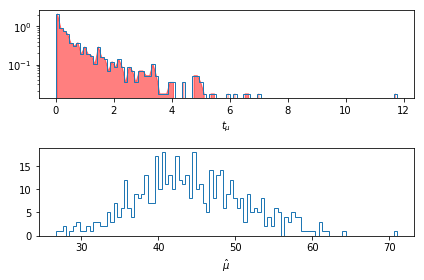

In [45]:
mu, mu0, size = muhat0, 0., 500
plt_mu_segment(ht, par, x0, mu, mu0, size)

We scan along $\mu$. Let's consider a low $\mu_l$ value and obtain the pdf of $g(t_\mu | \mu_l)$ and where is located $t_{\mu_l} (x_0)$ and its p-value.

 generating 500  events with mu  37.54744733029362 and mu0  0.0
 tmu  0.9889464814779103  of x0 at mu  37.54744733029362
 p-value : 0.322


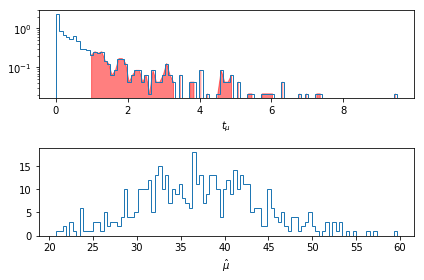

In [46]:
mu = mu_lower 
plt_mu_segment(ht, par, x0, mu, mu0, size)

We scan along $\mu$. Let's consider a high $\mu_u$ value and obtain the pdf of $g(t_\mu | \mu_u)$

 generating 500  events with mu  51.980322880476216 and mu0  0.0
 tmu  0.9889464814774556  of x0 at mu  51.980322880476216
 p-value : 0.304


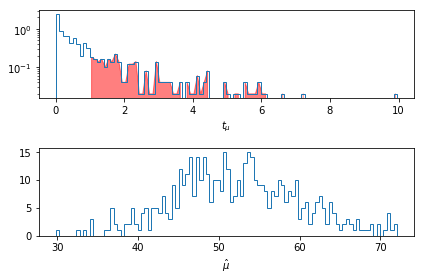

In [49]:
mu = mu_upper
plt_mu_segment(ht, par, x0, mu, mu0, size)

**Exercise**: Check is the case fulfills the Wilk's condition.

Generate $m$ (*size*) experiments with $\mu$ and check aht the $g(t_\mu | \mu)$ distribution is a $\chi^2(1)$.

 generating 500  events with mu  44.42510986328125 and mu0  0.0
chi2  0.9011962626770527
p-value mean : 0.5042861790583814 ; std * sqrt(12.) : 0.9646343162960805


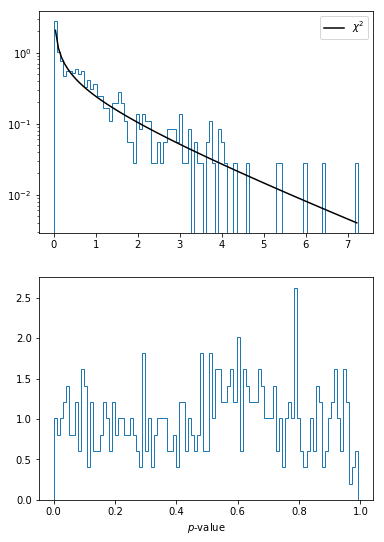

In [52]:
tmus, muhats = tmus_rvs(ht, par, mu = muhat0, mu0 = mu0, size = size)
htplot.chi2_test(tmus);

**Exercise**: Compute the CI at 68 % CL using $t_\mu(x)$ and the p0-value for the case $\mu_0 = 0$.

In [53]:
def plt_pvalues(ht, x0, mu0, mul, mup, nbins, beta):
    q0 = ht.q0(x0, 0., parbest = parbest0)
    p0 = htcore.q0_pvalue(q0)
    mus   = np.linspace(max(0., muhat0 - 20), muhat0 + 20, 100)
    tmus  = [ht.tmu(x0, mui, mu0 = mu0, parbest = parbest0) for mui  in mus]
    ptmus = [htcore.tmu_pvalue(tmui)             for tmui in tmus]
    htplot.plt_wilks_pvalues(beta, mus, ptmus);
    ci = ht.tmu_cint(x0, parbest = parbest0, beta = beta)
    htplot.prt_wilks_pvalues(beta, ci_central = ci, p0 = p0)

central CI  : [37.54744733 51.98032288] at  68 % CL
p0 value    : 0.0


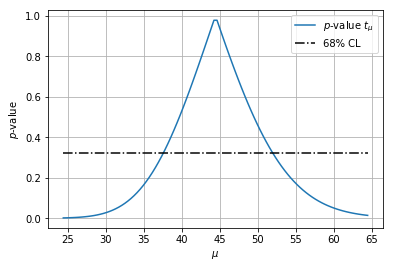

In [54]:
beta = 0.68
plt_pvalues(ht, x0, mu0, mul, mup, nbins, beta)

### Example: signal & control region

bkg events : 55 signal events : 2


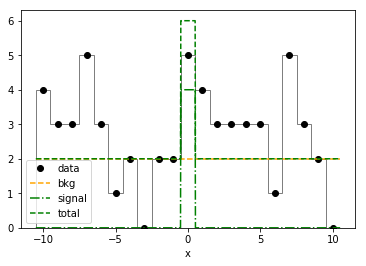

In [61]:
# the parameters of interest if *mu*, the number of signal events
mu, nu, tau = blind.mu, 2., 20. 
httoys.poisson_control_rvs(mu, nu, tau, tau + 1);

In [62]:
mu0        = 0.
par, mask, masknu  = [mu, nu, tau], [True, True, False], [False, True, False]

rv       = htcata.poisson_control_signal
x0       = rv.rvs(*par, size =1)[0]
ht       = htcore.htcomposite(rv, par, mask = mask, masknu = masknu) 
parbest0 = ht.parbest(x0, mu0 = mu0)
muhat0   = parbest0[0]

print('events in control, signal region :', x0[0], x0[1])
print('events in control region/tau     :', x0[0]/tau)
print('parbest(x0) :', parbest0)
print('muhat(x0)   :', muhat0)

events in control, signal region : 42.0 6.0
events in control region/tau     : 2.1
parbest(x0) : [ 3.89997168  2.09999886 20.        ]
muhat(x0)   : 3.8999716844746812


central CI  : [1.75310193 6.69253047] at  68 % CL


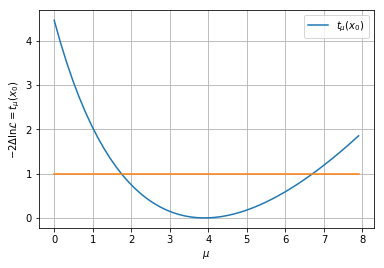

In [66]:
mu0, mul, mup, nbins, beta  = 0., max(0., muhat0 - 4), muhat0 + 4, 50, 0.68
ci = plt_llscan(ht, x0, mu0, beta, mul, mup, nbins)
mu_lower, mu_upper = ci

 generating 500  events with mu  1.7531019334144293 and mu0  0.0
 tmu  0.9889464814780222  of x0 at mu  1.7531019334144293
 p-value : 0.278


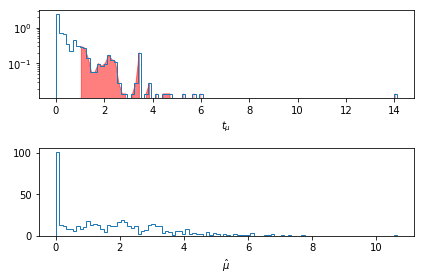

In [67]:
mu_lower = max(mu0, mu_lower)
plt_mu_segment(ht, par, x0, mu_lower, mu0, size)

 generating 500  events with mu  6.69253047206467 and mu0  0.0
 tmu  0.988946481478024  of x0 at mu  6.69253047206467
 p-value : 0.332


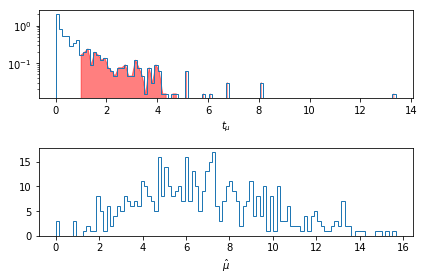

In [68]:
plt_mu_segment(ht, par, x0, mu_upper, mu0, size)

 generating 500  events with mu  3.8999716844746812 and mu0  0.0
chi2  1.065089133615348
p-value mean : 0.525625279012297 ; std * sqrt(12.) : 0.9937920479952305


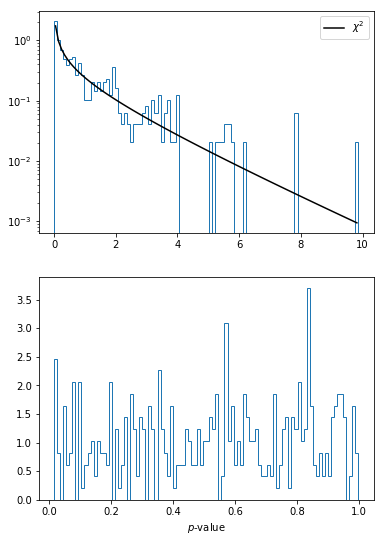

In [69]:
tmus, muhats = tmus_rvs(ht, par, mu = muhat0, mu0 = mu0, size = size)
htplot.chi2_test(tmus);

central CI  : [1.75310193 6.69253047] at  68 % CL
p0 value    : 0.017321272622027206


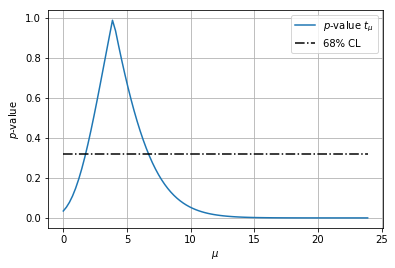

In [70]:
beta = 0.68
plt_pvalues(ht, x0, mu0, mul, mup, nbins, beta)

**Exercise**: Consider now a uniform backgrund $1.3 \times 10^{-4}$ c/(kg y keV) and and two gaussian peaks with sigma 1%, one signal peak, $^{136}$Xe at 2458 keV with unknown number of events and other background peak ($^{214}$Bi) at 2447 keV with 0.06 c/(keV y). Consider the range 2400-2500 keV. 

Compute the upper limit in number of signal events at 90% CL vs exposure in the case there is no signal. 

Compute the observation potential in the case the number of signal is 0.12 c/(keV y).